In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
import pandas as pd
import plotly.express as px
from scipy.integrate import dblquad

excel_file = pd.ExcelFile("/content/March_Madness_Basketball_Data.xlsx")


columns = {'offense': [], 'defense': [], 'wins': []}

# Load data from Excel file for each year and concatenate it
for i in range(2024, 2010, -1):
    if(i != 2020):
      df = pd.read_excel(excel_file, sheet_name=str(i), usecols=[1,2,3], header=None)
      columns['offense'].append(df.iloc[:, 0].values)  # 2nd column
      columns['defense'].append(df.iloc[:, 1].values)  # 3rd column
      columns['wins'].append(df.iloc[:, 2].values)  # 4th column

for key, value in columns.items():
    columns[key] = np.concatenate(value)

offense = columns['offense']
defense = columns['defense']
wins = columns['wins']

# normalize offensive and defensive effieciencies
max_o = np.max(offense)
min_o = np.min(offense)
max_d = np.max(defense)
min_d = np.min(defense)

norm_o = (offense - np.min(offense)) / (np.max(offense) - np.min(offense))
norm_d = (defense - np.min(defense)) / (np.max(defense) - np.min(defense))

# split offensive data into training and test data (2024 is test)
no_24 = norm_o[:68]
no = norm_o[68:]

# split defensive data into training and test data (2024 is test)
nd_24 = norm_d[:68]
nd = norm_d[68:]

# split wins into training and test data (2024 is test)
w_24 = wins[:68]
w = wins[68:]

In [ ]:
def fourier_coefficients(x, y, z, num_terms):
    Lx = np.max(x) - np.min(x)
    Ly = np.max(y) - np.min(y)

    # Initialize coefficients arrays
    a = np.zeros((num_terms, num_terms))
    b = np.zeros((num_terms, num_terms))

    for m in range(num_terms):
        for n in range(num_terms):
            cos_term = np.cos(2 * np.pi * m * x / Lx) * np.cos(2 * np.pi * n * y / Ly)
            sin_term = np.sin(2 * np.pi * m * x / Lx) * np.sin(2 * np.pi * n * y / Ly)

            # Compute Fourier coefficients
            a[m, n] = np.sum(z * cos_term) / len(x)
            b[m, n] = np.sum(z * sin_term) / len(x)

    return a, b

def fourier_series(x, y, a, b, Lx, Ly):
  series = 0.0
  num_terms = len(a)
  for m in range(num_terms):
    for n in range(num_terms):
        series += a[m, n] * np.cos(2 * np.pi * m * x / Lx) * np.cos(2 * np.pi * n * y / Ly)
        series += b[m, n] * np.sin(2 * np.pi * m * x / Lx) * np.sin(2 * np.pi * n * y / Ly)
  return series

In [ ]:
num_terms = 5

a, b = fourier_coefficients(no, nd, w, num_terms)

x_values = np.linspace(0, 1, 100)
y_values = np.linspace(0, 1, 100)

# Compute Fourier series values for each point
series_values = np.zeros((len(x_values), len(y_values)))
for i, x in enumerate(x_values):
    for j, y in enumerate(y_values):
        series_values[i, j] = 3.5 * fourier_series(x, y, a, b, 1, 1)

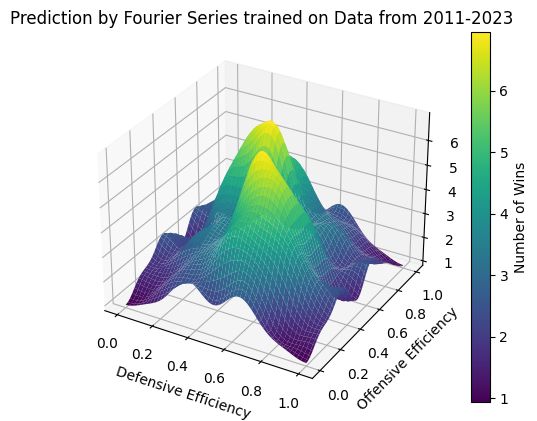

In [ ]:
X, Y = np.meshgrid(x_values, y_values)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surface = ax.plot_surface(Y, X, series_values, cmap='viridis')

ax.set_xlabel('Defensive Efficiency')
ax.set_ylabel('Offensive Efficiency')

ax.set_title('Prediction by Fourier Series trained on Data from 2011-2023')

# Adding a color bar to represent the Wins
cbar = fig.colorbar(surface)
cbar.set_label('Number of Wins')

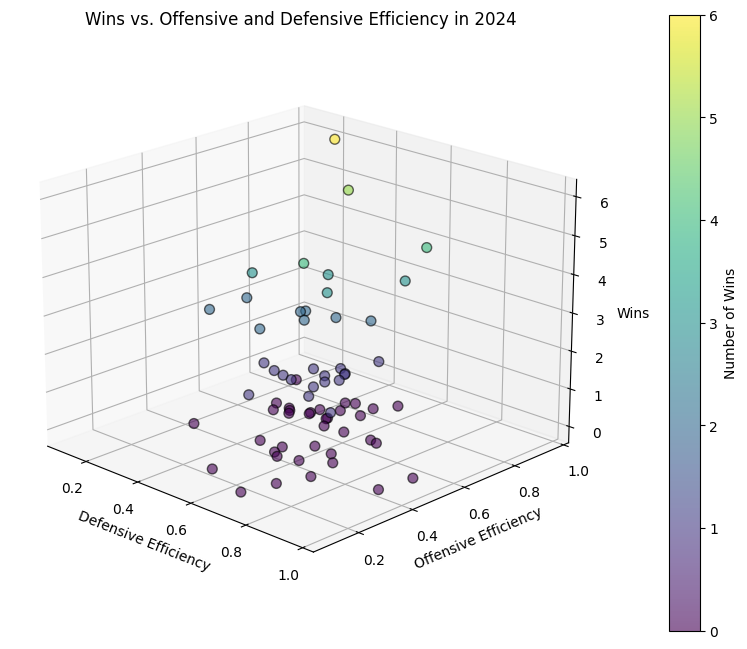

In [ ]:
# Create a new figure for the 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(nd_24, no_24, w_24, c=w_24, cmap='viridis', edgecolor='k', s=50, alpha=0.6)

ax.invert_xaxis()
ax.invert_yaxis()

# Labeling the axes
ax.set_xlabel('Defensive Efficiency')
ax.set_ylabel('Offensive Efficiency')
ax.set_zlabel('Wins')

# Adding a color bar to represent the Wins
cbar = fig.colorbar(scatter, pad=0.1)
cbar.set_label('Number of Wins')

# Adding a title
ax.set_title('Wins vs. Offensive and Defensive Efficiency in 2024')

# Enhanced interaction features like rotation
ax.view_init(elev=20, azim=134)  # Adjust the elevation and angle to optimize view

plt.show()
